In [72]:
import numpy as np
import matplotlib.pylab as plt
from copy import copy as cp
import matplotlib.patches as patches
from pint import UnitRegistry; AssignQuantity = UnitRegistry().Quantity

In [73]:
%matplotlib notebook

### Aesthetics ... function to fill in the box with a given constant value

In [74]:
def fillin(un,ixbox,iybox,overrideflag=0,overrideval=0):
    border = cp(un[ixbox.start-1,iybox.start])
    if(overrideflag == 1):
        border = overrideval
    un[ixbox,iybox] = border
    return un

### D interpolator
The coefficients m and b below are based on a fit of data from https://www.engineeringtoolbox.com/air-diffusion-coefficient-gas-mixture-temperature-d_2010.html.

In [75]:
def getDofT(T):
    """ This produces D in micrometers^2/microsecond"""
    m = 1.86121271
    b = -7.35421981
    logD = m*np.log(T)+b
    D = np.exp(logD)
    return D

def getDofTP(T,P):
    DofT = getDofT(T.magnitude); # print(DofT)
    P0 = AssignQuantity(1,'atm') 
    P = AssignQuantity(P,'atm')
    D = DofT/(P/P0)
    D = AssignQuantity(D.magnitude,'micrometers^2/microsecond')
    return D

### The differential equation solver

In [76]:
def propagate(u0_orig,ixbox,iybox,udirichlet,deltax_over_dx,deltay_over_dy,Dxeff,Dyeff):
    
    # Diffusion
    u0 = cp(u0_orig)
#     un = np.zeros(np.shape(u0))
    un = cp(u0_orig)
    un[1:-1, 1:-1] = u0[1:-1, 1:-1] + ( \
    (u0[2:, 1:-1] - 2*u0[1:-1, 1:-1] + u0[:-2, 1:-1])*Dxeff + \
    (u0[1:-1, 2:] - 2*u0[1:-1, 1:-1] + u0[1:-1, :-2])*Dyeff )

    # Dirichlet outer boundary
    un[[0,-1],:]=udirichlet
    un[:,[0,-1]]=udirichlet
        
    # Pull out the stop and start indices
    ixmin = ixbox.start
    ixmax = ixbox.stop-1
    iymin = iybox.start
    iymax = iybox.stop-1

    # Inner boundary: diffusion and Neumann
    un[ixmin-1,iybox] = u0[ixmin-1,iybox] +(u0[ixmin-2,iybox] - u0[ixmin-1,iybox])*Dxeff -deltax_over_dx*u0[ixmin-1,iybox]
    un[ixmax+1,iybox] = u0[ixmax+1,iybox] +(u0[ixmax+2,iybox] - u0[ixmax+1,iybox])*Dxeff -deltax_over_dx*u0[ixmax+1,iybox]

    un[ixbox,iymin-1] = u0[ixbox,iymin-1] +(u0[ixbox,iymin-2] - u0[ixbox,iymin-1])*Dyeff -deltay_over_dy*un[ixbox,iymin-1]
    un[ixbox,iymax+1] = u0[ixbox,iymax+1] +(u0[ixbox,iymax+2] - u0[ixbox,iymax+1])*Dyeff -deltay_over_dy*un[ixbox,iymax+1]
    
    # Also zero-out inside the box (this is just aesthetic)
#     un = fillin(un,ixbox, iybox, overrideflag=1, overrideval=0)
    
    return un

### Laying out the simulation space

In [77]:
nx = 353
ny = 353
xmax = AssignQuantity(1000,'micrometer')
ymax = AssignQuantity(1000,'micrometer')

x = np.linspace(0,xmax,nx); dx = x[1]-x[0]; print('dx', dx)
y = np.linspace(0,ymax,ny); dy = y[1]-y[0]; print('dy',dy)
dx2 = dx**2
dy2 = dy**2
nxmid = int(nx/2); # print('nxmid =', nxmid); # print('x(nxmid) =',x[nxmid])
nymid = int(ny/2)
x = x-x[nxmid]
y = y-y[nymid]

# Compute diffusion coefficient of water through air at this temperature (lost the source on this)
Temp = AssignQuantity(270,'kelvin')
Pressure = AssignQuantity(.1,'atm') # Don't remember where I got this from

# This is from engineering toolbox, with the power correction
D_273 = AssignQuantity(0.219,'cm^2/s')
D_273.ito('micrometer^2/microsecond'); print(D_273)
T0 = AssignQuantity(273,'kelvin')
P0 = AssignQuantity(1,'atm') 
acoef = 2.072
D = D_273*(Temp/T0)**acoef/(Pressure/P0); print('acoef method says D = ', D)

# This is using trends from engineering toolbox, with the log-log correction
D = getDofTP(Temp,Pressure); print('loglog method says D = ', D)


dt = (dx2+dy2)/D/10; print('dt = ', dt)
Dxeff = D*dt/dx2; print('Dxeff = ', Dxeff)
Dyeff = D*dt/dy2; print('Dyeff = ', Dyeff)

dx 2.840909090909091 micrometer
dy 2.840909090909091 micrometer
21.900000000000002 micrometer ** 2 / microsecond
acoef method says D =  214.04290150198355 micrometer ** 2 / microsecond
loglog method says D =  214.48062094134963 micrometer ** 2 / microsecond
dt =  0.007525868236848206 microsecond
Dxeff =  0.19999999999999998 dimensionless
Dyeff =  0.19999999999999998 dimensionless


### Working on the Neumann boundary condition

In [78]:
P3 = AssignQuantity(611,'Pa')
R = AssignQuantity(8.314,'J/mol/K')
T3 = AssignQuantity(273,'kelvin')

Delta_H_sub = AssignQuantity(50,'kJ/mol')
P_vapor_eq = P3*np.exp(-Delta_H_sub/R*(1/Temp-1/T3)); print('Vapor pressure at this temperature = ', P_vapor_eq)

density_ice = AssignQuantity(1,'g/cm^3')
molarmass_ice = AssignQuantity(18,'g/mol')
kappa = P_vapor_eq/(R*T3)/(density_ice/molarmass_ice)
kappa.ito('dimensionless')
print('kappa = ', kappa)

# This value comes from the CM
g_ice = AssignQuantity(2,'micrometer/second')

# Converting that to g(vapor)
g_vap = g_ice/kappa
print('g_vap = ', g_vap)

deltax = g_vap*dt
deltax.ito('micrometer')
deltay = deltax
print('distance of vapor consumed each time step = ', deltax)
deltax_over_dx = deltax/dx
print('deltax_over_dx (%) = ', deltax_over_dx*100)
deltay_over_dy = deltay/dy
print('deltay_over_dy (%) = ', deltay_over_dy*100)

Vapor pressure at this temperature =  478.34338486742547 pascal
kappa =  3.7934958235474035e-06 dimensionless
g_vap =  527218.1895088379 micrometer / second
distance of vapor consumed each time step =  0.0039677746263131804 micrometer
deltax_over_dx (%) =  0.13966566684622395 dimensionless
deltay_over_dy (%) =  0.13966566684622395 dimensionless


In [79]:
# This is the far-field boundary
sigma0 = 0.2
sigmaII_far_field = 0.1762 # This produces sigmaI = 0.22 at L=50 um
# sigmaII_far_field = 0.3 # This changes sigmaI, but doesn't change c_r(L)
sigmaI_far_field = sigmaII_far_field + sigma0
print('sigmaI_far_field = ', sigmaI_far_field)
print('sigmaII_far_field = ', sigmaII_far_field)
udirichlet = P_vapor_eq*(sigmaI_far_field+1)
print('udirichlet = ', udirichlet)

sigmaI_far_field =  0.5
sigmaII_far_field =  0.3
udirichlet =  717.5150773011383 pascal


In [80]:
# # This restarts the array accumulation
Lx_list = np.array([])
Ly_list = np.array([])
uslicex_list = np.array([])
uslicey_list = np.array([])
c_rx_list = np.array([])
c_ry_list = np.array([])

# Looping
Ldesired_list = AssignQuantity(np.arange(20,90,5),'micrometer')
# Ldesired_list = AssignQuantity(np.arange(50,51,1),'micrometer')
# Ldesired_list = AssignQuantity(np.arange(46,55,2),'micrometer')
aspect_ratio = 1
for Ldesired in Ldesired_list:
    
    # Define the box inside
    Ldesiredx = Ldesired # Doesn't always work out to this because the grid is discretized
    boxradx = int(Ldesiredx/dx)
    Lx = boxradx*dx; 
    
    Ldesiredy = Ldesiredx*aspect_ratio
    boxrady = int(Ldesiredy/dy)
    Ly = boxrady*dy; 

    ixboxmin = nxmid-boxradx
    ixboxmax = nxmid+boxradx
    iyboxmin = nymid-boxrady
    iyboxmax = nymid+boxrady

    # Setting up to slice through the volume
    ixbox = slice(ixboxmin,ixboxmax); # print(ixbox)
    iybox = slice(iyboxmin,iyboxmax); # print(iybox)

    # Initialize u0 and un as ones/zeros matrices 
    u0 = np.ones([nx, ny])*udirichlet # old u values

    # Initialize the state of the vapor field
    un = cp(u0)

    # Propagate forward a bunch of times
    ntimes = 3000
    for i in range(ntimes):
        un = propagate(un,ixbox,iybox,udirichlet,deltax_over_dx,deltay_over_dy,Dxeff,Dyeff)

    # Now a slice just across one of the box surfaces (in the x dimension)
    uslicex = un[ixbox,nymid+boxrady]
    c_rx = (max(uslicex)-min(uslicex))/uslicex[0]*100

    # Now a slice just across one of the box surfaces (in the Y dimension)
    uslicey = un[nxmid+boxradx, iybox]
    c_ry = (max(uslicey)-min(uslicey))/uslicey[0]*100

    # Accumulate
    Lx_list = np.append(Lx_list,Lx)
    Ly_list = np.append(Ly_list,Ly)
    uslicex_list = np.append(uslicex_list,uslicex[0])
    uslicey_list = np.append(uslicey_list,uslicey[0])
    c_rx_list = np.append(c_rx_list,c_rx)
    c_ry_list = np.append(c_ry_list,c_ry)
    
    # Reporting
    print('Done with Lxdesired, Lx = ', Ldesired, Lx)

Done with Lxdesired, Lx =  20 micrometer 19.886363636363637 micrometer
Done with Lxdesired, Lx =  25 micrometer 22.727272727272727 micrometer
Done with Lxdesired, Lx =  30 micrometer 28.409090909090907 micrometer
Done with Lxdesired, Lx =  35 micrometer 34.09090909090909 micrometer
Done with Lxdesired, Lx =  40 micrometer 39.77272727272727 micrometer
Done with Lxdesired, Lx =  45 micrometer 42.61363636363636 micrometer
Done with Lxdesired, Lx =  50 micrometer 48.29545454545455 micrometer
Done with Lxdesired, Lx =  55 micrometer 53.97727272727273 micrometer
Done with Lxdesired, Lx =  60 micrometer 59.65909090909091 micrometer
Done with Lxdesired, Lx =  65 micrometer 62.5 micrometer
Done with Lxdesired, Lx =  70 micrometer 68.18181818181819 micrometer
Done with Lxdesired, Lx =  75 micrometer 73.86363636363636 micrometer
Done with Lxdesired, Lx =  80 micrometer 79.54545454545455 micrometer
Done with Lxdesired, Lx =  85 micrometer 82.38636363636364 micrometer


<IPython.core.display.Javascript object>


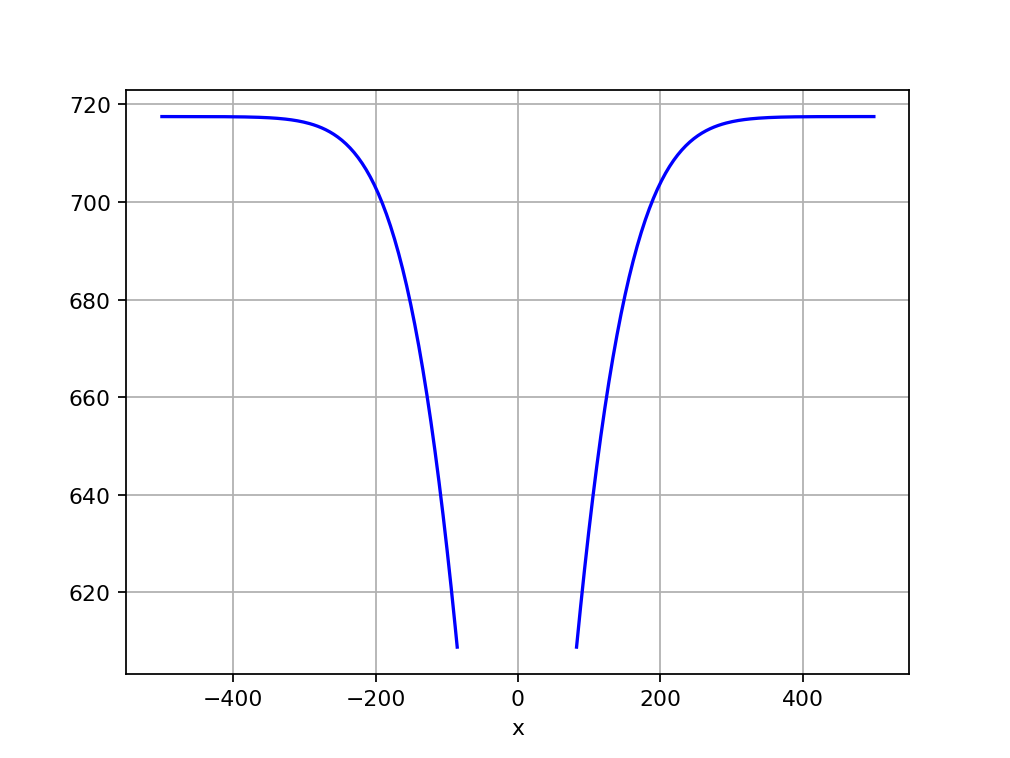

<IPython.core.display.Javascript object>


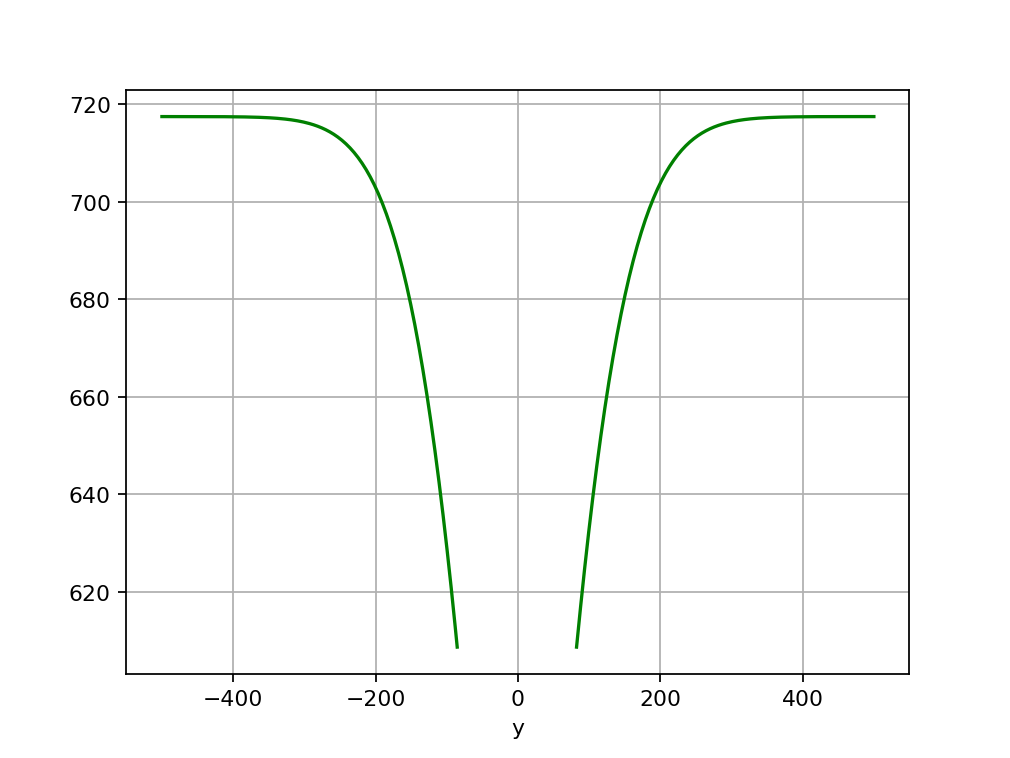

<IPython.core.display.Javascript object>


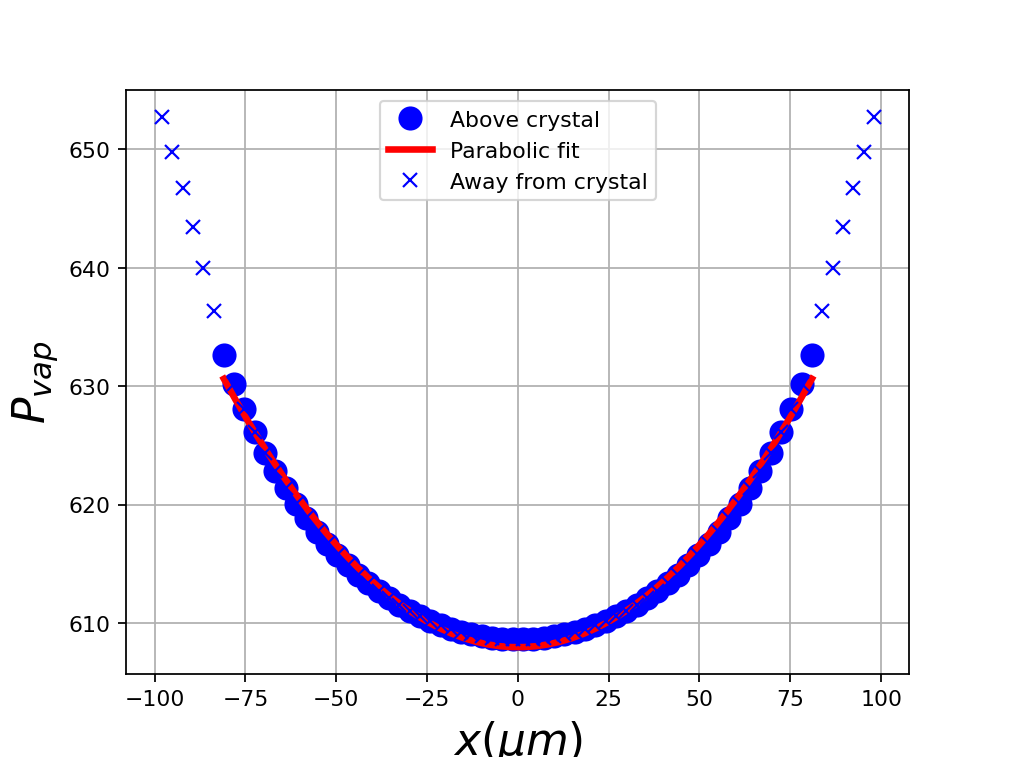

<IPython.core.display.Javascript object>


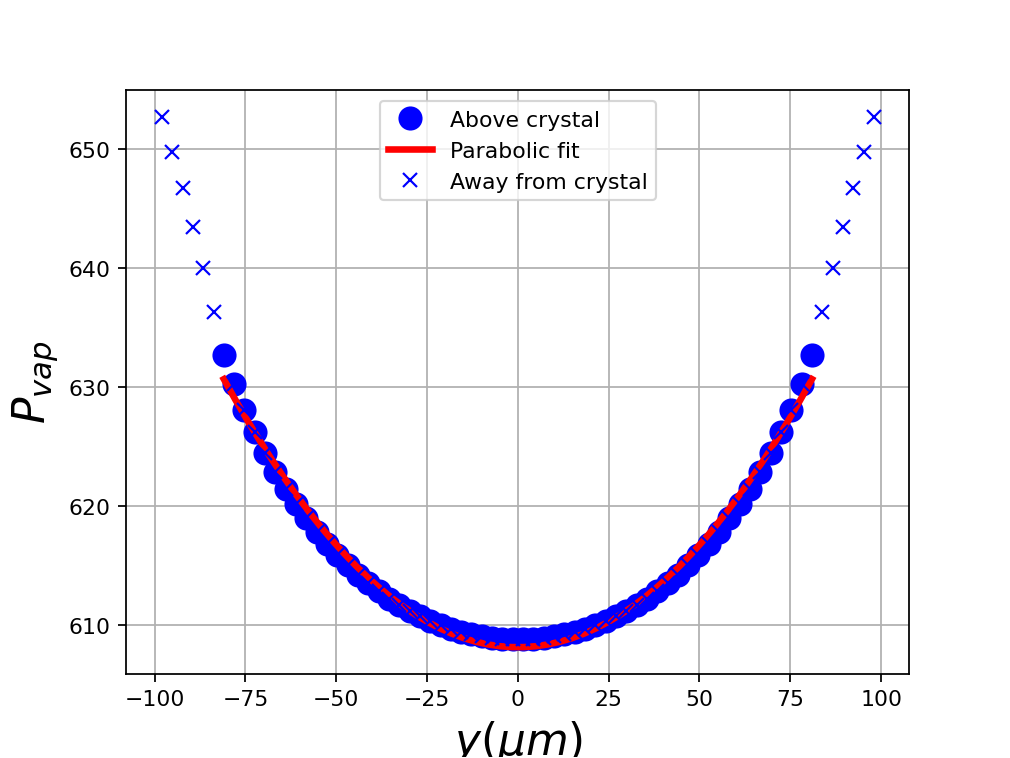

<IPython.core.display.Javascript object>


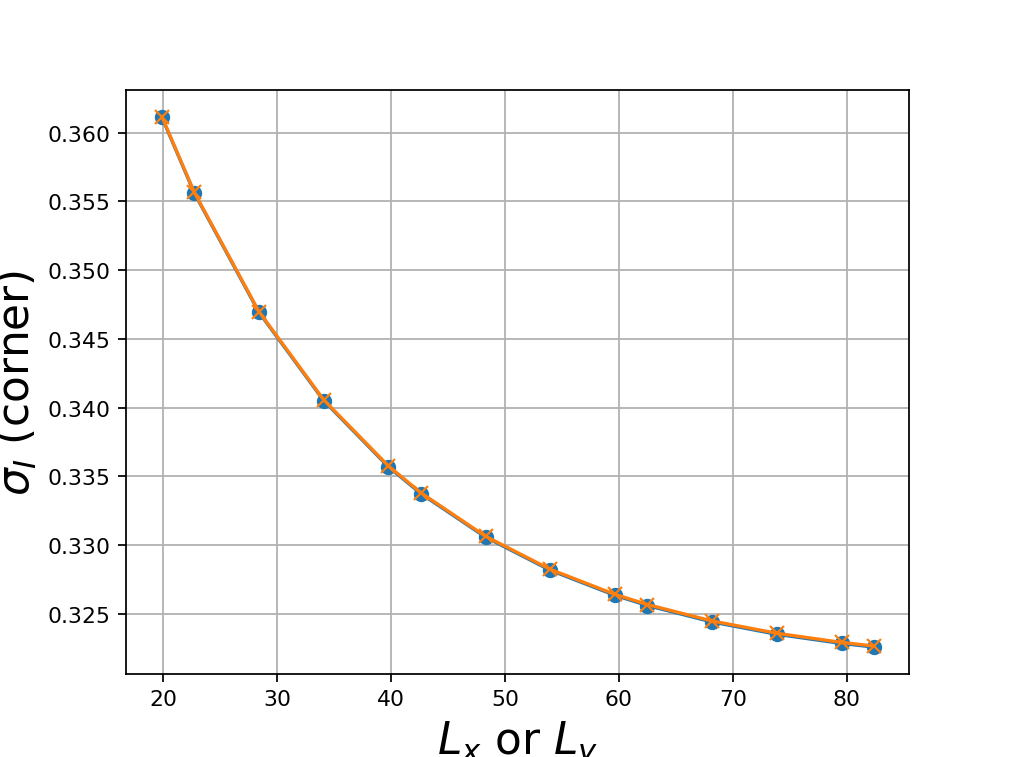

<IPython.core.display.Javascript object>


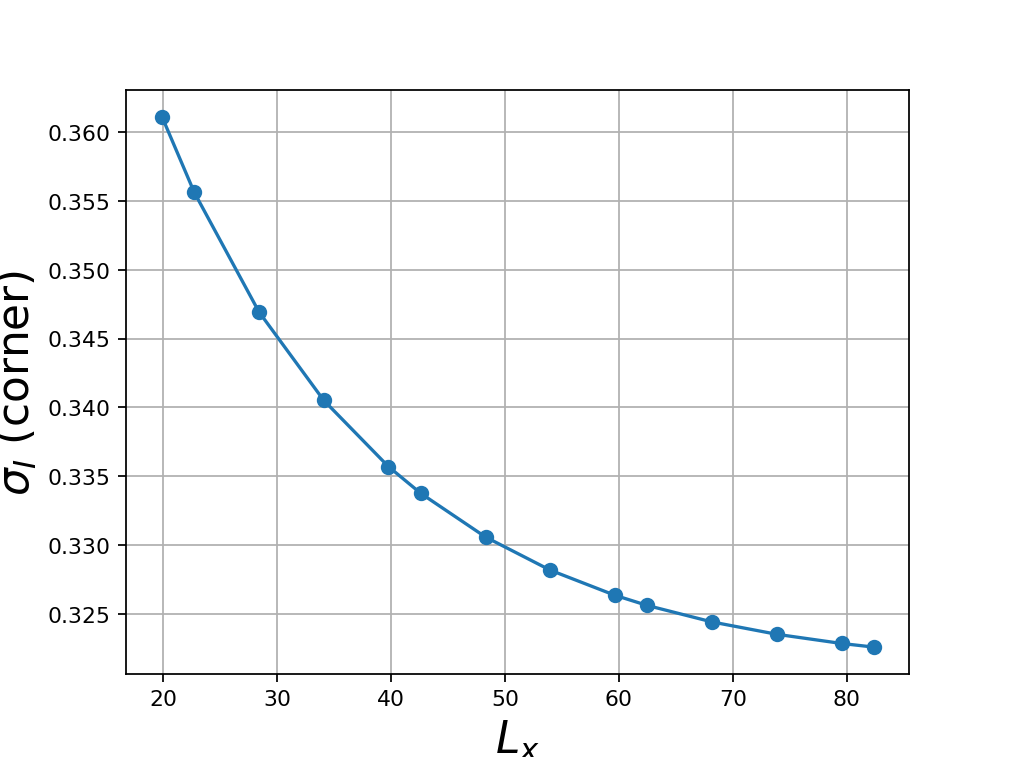

<IPython.core.display.Javascript object>


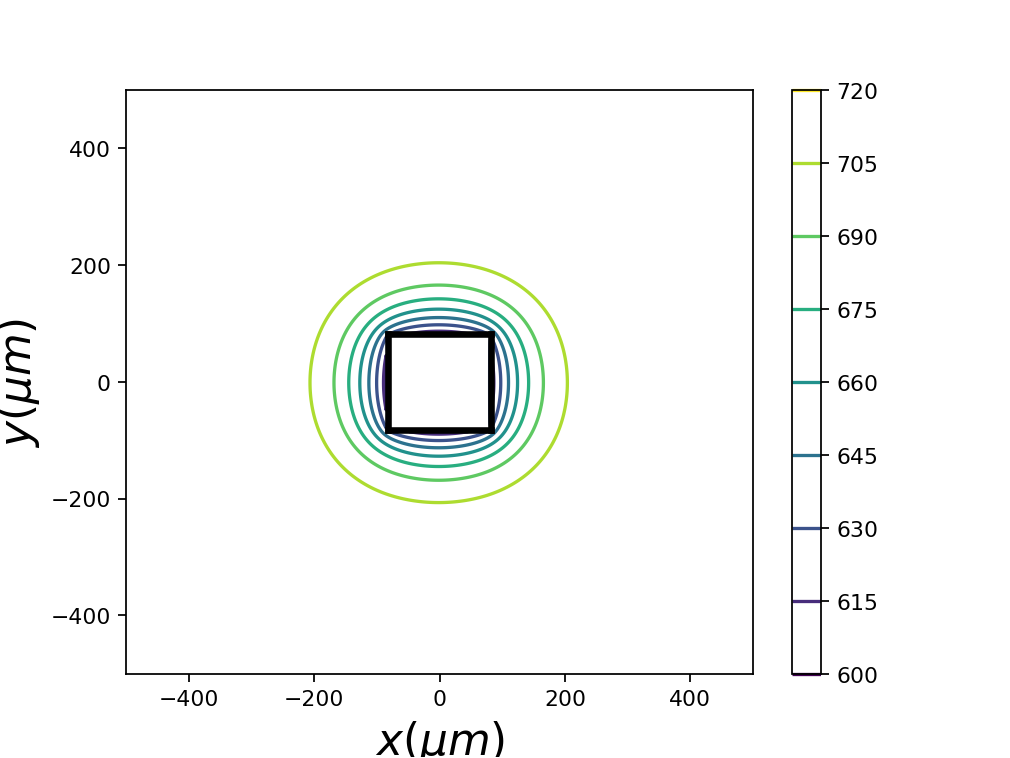

<IPython.core.display.Javascript object>


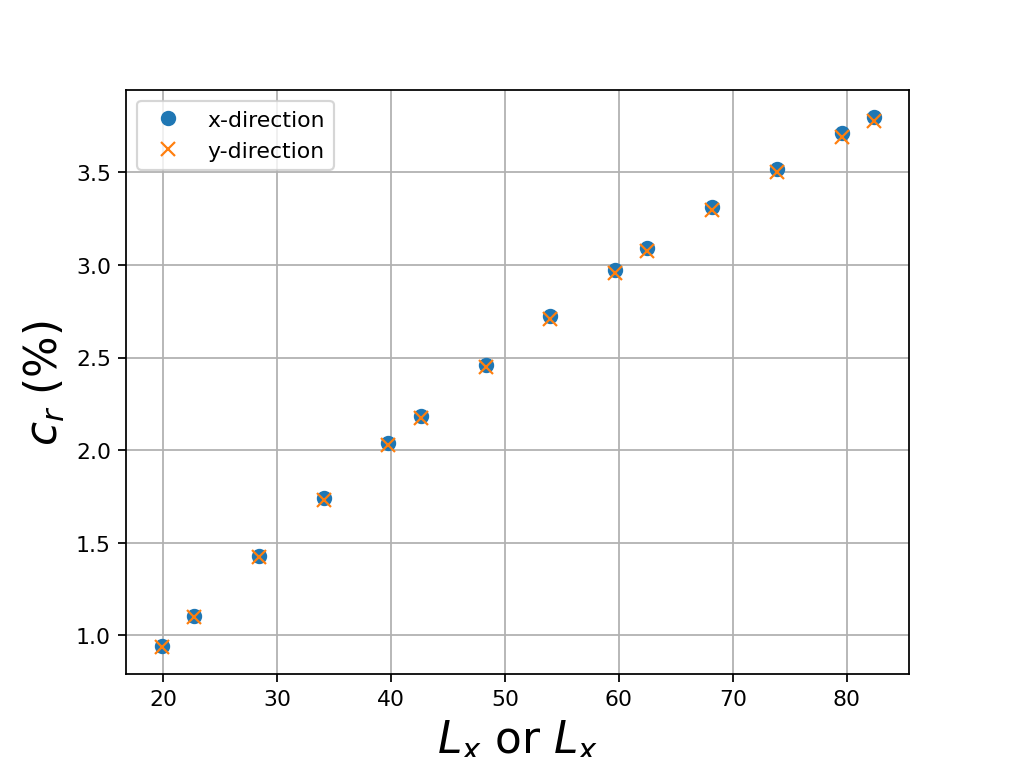

<IPython.core.display.Javascript object>


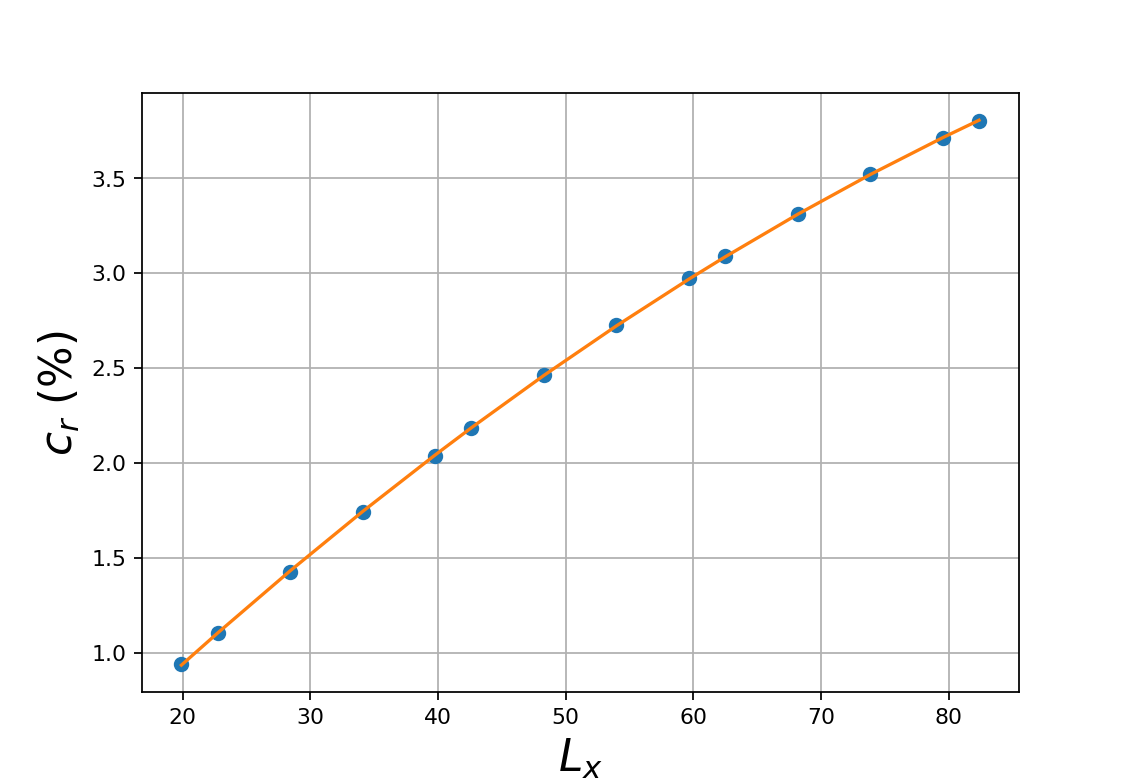

For D =  214.48062094134963 micrometer ** 2 / microsecond
px = [-2.28828823e-04  6.93168323e-02 -3.52882404e-01]


In [81]:
# Filling in where the crystal is
fillin(un,ixbox,iybox)

# Plotting from far afield up to the box
iextend = 6
fontsize = 20
color = 'k'
linewidth = 3
markersize = 10

ixbox_pre = slice(0,ixboxmin)
ixbox_post = slice(ixboxmax,nx)
plt.figure()
plt.plot(x[ixbox_pre], un[ixbox_pre,nymid], 'blue')
plt.plot(x[ixbox_post],un[ixbox_post,nymid],'blue')
plt.xlabel('x')
plt.grid(True)

iybox_pre = slice(0,iyboxmin)
iybox_post = slice(iyboxmax,ny)
plt.figure()
plt.plot(y[iybox_pre], un[nxmid,iybox_pre], 'green')
plt.plot(y[iybox_post],un[nxmid,iybox_post],'green')
plt.xlabel('y')
plt.grid(True)

# This is right above the surface in the x-direction
plt.figure()
xshifted = x[ixbox]-x[nxmid]+dx/2
plt.plot(xshifted,uslicex,'ob',label='Above crystal',lw=linewidth,ms=markersize)
p = np.polyfit(xshifted.magnitude,uslicex.magnitude,2); #print(p)
xshifted_theory = np.linspace(min(xshifted),max(xshifted))
plt.plot(xshifted_theory,np.polyval(p,xshifted_theory.magnitude),'-r',label='Parabolic fit',lw=linewidth)
bigixbox = [ix for ix in range(nxmid-boxradx-iextend,nxmid+boxradx+iextend)]
biguslice = un[bigixbox,nymid+boxrady]
bigxshifted = x[bigixbox]-x[nxmid]+dx/2
plt.plot(bigxshifted,biguslice,'xb', label='Away from crystal',lw=linewidth)
plt.xlabel(r'$x (\mu m)$', fontsize=fontsize)
plt.ylabel(r'$P_{vap}$',fontsize=fontsize)
plt.legend()
plt.grid(True)

# This is right above the surface in the y-direction
plt.figure()
yshifted = y[iybox]-y[nymid]+dy/2
plt.plot(yshifted,uslicey,'ob',label='Above crystal',lw=linewidth,ms=markersize)
p = np.polyfit(yshifted.magnitude,uslicey.magnitude,2); #print(p)
yshifted_theory = np.linspace(min(yshifted),max(yshifted))
plt.plot(yshifted_theory,np.polyval(p,yshifted_theory.magnitude),'-r',label='Parabolic fit',lw=linewidth)
bigiybox = [iy for iy in range(nymid-boxrady-iextend,nymid+boxrady+iextend)]
biguslice = un[nxmid+boxradx,bigiybox]
bigyshifted = y[bigiybox]-y[nymid]+dy/2
plt.plot(bigyshifted,biguslice,'xb', label='Away from crystal',lw=linewidth)
plt.xlabel(r'$y (\mu m)$', fontsize=fontsize)
plt.ylabel(r'$P_{vap}$',fontsize=fontsize)
plt.legend()
plt.grid(True)

# Plotting the surface supersaturation at the corner of the crystal
plt.figure()
sigmaDx = uslicex_list/P_vapor_eq-1
sigmaDy = uslicey_list/P_vapor_eq-1
plt.plot(Lx_list,sigmaDx,'-o')
plt.plot(Ly_list,sigmaDy,'-x')
plt.xlabel(r'$L_x$ or $L_y$',fontsize=fontsize)
plt.ylabel(r'$\sigma_I$ (corner)',fontsize=fontsize)
plt.grid(True)

# Plotting the surface supersaturation at the corner of the crystal
plt.figure()
plt.plot(Lx_list,sigmaDx,'-o')
plt.xlabel(r'$L_x$',fontsize=fontsize)
plt.ylabel(r'$\sigma_I$ (corner)',fontsize=fontsize)
plt.grid(True)

# Graph as contour plot
fig,ax = plt.subplots()
CS = ax.contour(x,y,un.T)
ax.set_xlabel(r'$x (\mu m)$', fontsize=fontsize)
ax.set_ylabel(r'$y (\mu m)$', fontsize=fontsize)
fig.colorbar(CS)
xvec = (x[ixboxmin].magnitude,x[ixboxmin].magnitude)
yvec = (y[iyboxmin].magnitude,y[iyboxmax].magnitude)
plt.plot(xvec,yvec,color=color,linewidth=linewidth)
xvec = (x[ixboxmax].magnitude,x[ixboxmax].magnitude)
yvec = (y[iyboxmin].magnitude,y[iyboxmax].magnitude)
plt.plot(xvec,yvec,color=color,linewidth=linewidth)
xvec = (x[ixboxmin].magnitude,x[ixboxmax].magnitude)
yvec = (y[iyboxmin].magnitude,y[iyboxmin].magnitude)
plt.plot(xvec,yvec,color=color,linewidth=linewidth)
xvec = (x[ixboxmin].magnitude,x[ixboxmax].magnitude)
yvec = (y[iyboxmax].magnitude,y[iyboxmax].magnitude)
plt.plot(xvec,yvec,color=color,linewidth=linewidth)

# The center reduction
plt.figure()
plt.plot(Lx_list,c_rx_list, 'o',label='x-direction')
plt.plot(Ly_list,c_ry_list, 'x',label='y-direction')
plt.xlabel(r'$L_x$ or $L_x$',fontsize=fontsize)
plt.ylabel(r'$c_r$ (%)', fontsize=fontsize)
plt.legend()
plt.grid(True)

# The center reduction
plt.figure()
plt.plot(Lx_list,c_rx_list, 'o',label='x-direction')
plt.xlabel(r'$L_x$',fontsize=fontsize)
plt.ylabel(r'$c_r$ (%)', fontsize=fontsize)
plt.grid(True)

if len(Lx_list) > 1:
    print('For D = ', D)
    px = np.polyfit(Lx_list.magnitude,c_rx_list.magnitude,2); print('px =', px)
    plt.plot(Lx_list,plt.polyval(px,Lx_list.magnitude))
#     py = np.polyfit(Ly_list.magnitude,c_ry_list.magnitude,2); print('py =', py)
#     plt.plot(Ly_list,plt.polyval(py,Ly_list.magnitude))

### Doing this again to sort out the relaxation time after a perturbation

In [82]:
# un_perturbed = cp(un)
# un_perturbed[nxmid,nymid+boxrady] = .20
# un_perturbed[nxmid-1,nymid+boxrady] = .20
# uslice_perturbed = un_perturbed[ixbox,nymid+boxrady]

# # Propagate forward a bunch of times
# ntimes_after_perturbation = 400
# ukeep = []
# tkeep = []
# count = -1
# for i in range(ntimes_after_perturbation):
#     un_perturbed = propagate(un_perturbed,ixbox,iybox,gneumanneffx,gneumanneffy,Dxeff,Dyeff)
#     count+=1
#     ukeep.append(un_perturbed[nxmid,nymid+boxrady])
#     tkeep.append(dt*count)
# tkeep = np.array(tkeep)

# uslice_perturbed_relaxed = un_perturbed[ixbox,nymid+boxrady]
# plt.figure()
# plt.plot(xshifted,uslice_perturbed*100,'s')
# plt.plot(xshifted,uslice_perturbed_relaxed*100,'o')
# plt.grid(True)

# plt.figure()
# f = (ukeep-ukeep[-1])/(ukeep[0]-ukeep[-1])
# plt.plot(tkeep,f)
# plt.xlabel('time (microseconds)')
# plt.grid(True)
# tau = tkeep[np.argmin(np.abs(f-.5))]
# print('Approximate half-life =',tau)